In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model, Sequential
from keras.layers import Input, Dense, Dropout
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve,auc,confusion_matrix, accuracy_score, precision_score, \
                            recall_score, matthews_corrcoef

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier,\
                             VotingClassifier
from sklearn.svm import OneClassSVM
import featuretools as ft
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from IPython.display import display,clear_output,HTML

Using TensorFlow backend.
/nethomes/darshan/anaconda3/lib/python3.6/site-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/nethomes/darshan/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/nethomes/darshan/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please impor

In [2]:
### Read HTML 
df_html=pd.read_csv('../html/HTML.csv',index_col='domain')
df_html.drop(['Unnamed: 0'],axis=1,inplace=True)
cookie=[col for col in df_html.columns if 'number' in col]
df_html.drop(cookie,axis=1,inplace=True)
print("Shape of HTML dataset:",df_html.shape)
df_html.Target=df_html.Target.apply(lambda x: 1 if x=='Malicious' else 0)
count_columns=[col for col in df_html.columns if col.endswith('count')]
df_html['total_count']=df_html[count_columns].sum(axis=1)

href_columns=[col for col in df_html.columns if (('href_absolute' in col) | ('href_relative' in col) | ('href_page' in col))  ]
df_html['total_href']=df_html[href_columns].sum(axis=1)

total_img_src=[col for col in df_html.columns if 'img_src_' in col]
df_html['total_img_src']=df_html[total_img_src].sum(axis=1)


### Read JS 
df_js=pd.read_csv('Javascript.csv',low_memory=False,index_col='domain')
cookie=[col for col in df_js.columns if 'number' in col]
df_js.drop(cookie,axis=1,inplace=True)
df_js.rename(columns={'Malicious':'Target'},inplace=True)
print("Shape of JS,DOM dataset:",df_js.shape)
df_js.Target=df_js.Target.apply(lambda x: 1 if x=='Malicious' else 0)


### Read HTTP
df_http=pd.read_csv('HTTP.csv')
df_http.rename(columns={'Malicious':'Target'},inplace=True)
df_http.fillna(value=0,inplace=True)
cookies=[columns for columns in df_http.columns if 'number' in columns]
df_http.drop(cookies,axis=1,inplace=True)
df_http=df_http[df_http['domain']!=0]
df_http.sort_values(by='Target',inplace=True,ascending=False)
df_http.drop_duplicates(['domain'], keep='first',inplace=True)
df_http=df_http.sample(frac=1,random_state=0)
df_http.set_index(['domain'],drop=True,inplace=True)
print("Shape of HTTP dataset:",df_http.shape)



### Read URL
df_url=pd.read_csv('URL.csv')
df_url.fillna(value=0,inplace=True)
cookies=[columns for columns in df_url.columns if 'number' in columns]
df_url.drop(cookies,axis=1,inplace=True)
df_url.drop(['url_host','url_ip'],axis=1,inplace=True)
df_url=df_url[df_url['domain']!=0]
df_url.sort_values(by='Target',inplace=True,ascending=False)
df_url.drop_duplicates(['domain'], keep='first',inplace=True)
df_url=df_url.sample(frac=1,random_state=0)
print("Shape of URL dataset:",df_url.shape)
df_url.set_index('domain',inplace=True,drop=True)

df=pd.concat([df_js,df_html,df_http,df_url],axis=1,join='inner')
df.drop(['Unnamed: 0'],axis=1,inplace=True)
df['Target_z']=df[['Target','Target','Target','Target']].apply(max,axis=1)
df.drop(['Target','Target','Target','Target'],axis=1,inplace=True)
print("Shape of combined dataset:",df.shape)
df.rename(columns={'Target_z':'Target'},inplace=True)
df.Target.value_counts()

Shape of HTML dataset: (43491, 1461)
Shape of JS,DOM dataset: (43294, 401)
Shape of HTTP dataset: (45856, 672)


/nethomes/darshan/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (76,77,229,230,231,232,233,234,235,236,237,238,239,240,241,242,244,245,246,247,248,249,250,251,252,253,254,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,

Shape of URL dataset: (46771, 4194)
Shape of combined dataset: (39183, 6726)


0    34742
1     4441
Name: Target, dtype: int64

In [3]:
columns=['js_function_.push(',
 'a_count',
 'a_href_http',
 'a_href_https',
 'a_href_out_of_domain',
 'a_href_relative',
 'center_count',
 'form_action_http',
 'iframe_src_.html',
 'img_src_http',
 'link_href_out_of_domain',
 'link_type_text/css',
 'meta_count',
 'p_count',
 'script_async_true',
 'total_count',
 'total_href',
 'http_header_cache-control_set_max-age',
 'http_header_content-encoding_gzip',
 'http_header_server_apache',
 'http_header_transfer-encoding_chunked',
 'http_header_vary_user-agent',
 'http_header_via_1.1',
 'url_char_.',
 'url_char_f',
 'url_char_i',
 'url_char_l',
 'url_char_p',
 'url_char_w',
 'url_char_y',
 'url_char_z',
 'url_extension_.com',
 'url_extensions',
 'url_length',
 'Target']

df['url_extension_endswith_.com']=df['url_extension_endswith_.com'].apply(lambda x: 1 if x==True else x)
df['url_extension_endswith_.com']=df['url_extension_endswith_.com'].astype(int)
print("features being used")
display(columns)
df_sel=df[columns].copy(deep=True)

features being used


['js_function_.push(',
 'a_count',
 'a_href_http',
 'a_href_https',
 'a_href_out_of_domain',
 'a_href_relative',
 'center_count',
 'form_action_http',
 'iframe_src_.html',
 'img_src_http',
 'link_href_out_of_domain',
 'link_type_text/css',
 'meta_count',
 'p_count',
 'script_async_true',
 'total_count',
 'total_href',
 'http_header_cache-control_set_max-age',
 'http_header_content-encoding_gzip',
 'http_header_server_apache',
 'http_header_transfer-encoding_chunked',
 'http_header_vary_user-agent',
 'http_header_via_1.1',
 'url_char_.',
 'url_char_f',
 'url_char_i',
 'url_char_l',
 'url_char_p',
 'url_char_w',
 'url_char_y',
 'url_char_z',
 'url_extension_.com',
 'url_extensions',
 'url_length',
 'Target']

In [4]:
def model_build(model,X_train,Y_train,X_test,Y_test,tree=False,feat=None):
    
    y_pred_train=model.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    print("Accuracy of the model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    display(pd.crosstab(Y_train,y_pred_train))
    
    
    y_pred_test=model.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the model for test data is:",acc_test)
    print("Confusion Matrix for test data is:")
    display(pd.crosstab(Y_test,y_pred_test))

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    mcc=matthews_corrcoef(Y_test,y_pred_test)
    
    precision=precision_score(Y_test,y_pred_test)
    recall=recall_score(Y_test,y_pred_test)
    if tree==True:
#         feat_impt_plot(model.feature_importances_,feat)
        return model,acc_train,acc_test,roc_auc,model.feature_importances_,mcc,precision,recall
    
    return model,acc_train,acc_test,roc_auc,mcc,precision,recall

def KNN_model(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'K-Nearest Neighbors' + '\033[0m')
    knn=KNeighborsClassifier()
    knn.fit(X_train,Y_train)

    return model_build(knn,X_train,Y_train,X_test,Y_test)

# def Logistic_model(X_train,Y_train,X_test,Y_test):
#     print('\033[1m' + 'Logistic Regression' + '\033[0m')
#     log=LogisticRegression()
#     log.fit(X_train,Y_train)
    
#     return model_build(log,X_train,Y_train,X_test,Y_test)

def RandomForest(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'RandomForest Classifier' + '\033[0m')
    rf=RandomForestClassifier(n_estimators=10,random_state=0)
    rf.fit(X_train,Y_train)

    
    return model_build(rf,X_train,Y_train,X_test,Y_test,True,feat)

def AdaBoost(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'Adaoost Classifier' + '\033[0m')
    ada=AdaBoostClassifier(random_state=0)
    ada.fit(X_train,Y_train)
    
    return model_build(ada,X_train,Y_train,X_test,Y_test,True,feat)

def GradientBoosting(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'GradientBoosting Classifier' + '\033[0m')
    gbc=GradientBoostingClassifier(n_estimators=100,random_state=0)
    gbc.fit(X_train,Y_train)
    
    return model_build(gbc,X_train,Y_train,X_test,Y_test,True,feat)

def ExtraTree(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'ExtraTree Classifier' + '\033[0m')
    ext_tree=ExtraTreesClassifier(random_state=0)
    ext_tree.fit(X_train,Y_train)
    
    return model_build(ext_tree,X_train,Y_train,X_test,Y_test,True,feat)

def XGB(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'XGB Classifier' + '\033[0m')
    xgb=XGBClassifier(random_state=0)
    xgb.fit(X_train,Y_train)
    
    return model_build(xgb,X_train,Y_train,X_test,Y_test,True,feat)

def Bagging(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Bagging Classifier' + '\033[0m')
    bagging=BaggingClassifier(random_state=0)
    bagging.fit(X_train,Y_train)
    
    return model_build(bagging,X_train,Y_train,X_test,Y_test)

def XGB(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'XGB Classifier' + '\033[0m')
    xgb=XGBClassifier(random_state=0)
    xgb.fit(X_train,Y_train)
    
    return model_build(xgb,X_train,Y_train,X_test,Y_test,True,feat)

def DeepLearning1(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Neural Network-1' + '\033[0m')
    np.random.seed(0)
    deep_learning=Sequential()
    deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=X_train.shape[1]))
    deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
    deep_learning.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    deep_learning.fit(X_train,Y_train,batch_size=20,epochs=80,verbose=False)
    acc_train=deep_learning.evaluate(X_train,Y_train,verbose=False)[1]
    print("The accuracy of the model on training data is:",acc_train)
    display(pd.crosstab(Y_train,deep_learning.predict_classes(X_train,batch_size=1,verbose=False).reshape(1,len(X_train))[0]))
    acc_test=accuracy_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
    print("The accuracy of the model on test data is:",acc_test)
    display(pd.crosstab(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0]))
    mcc=matthews_corrcoef(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
    precision=precision_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
    recall=recall_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
    return  deep_learning,acc_train,acc_test,roc_auc,mcc,precision,recall

### 1. No Sampling

In [5]:
X_train, X_test = train_test_split(df_sel, test_size=0.2, random_state=42)

Y_train = X_train['Target']
X_train = X_train.drop(['Target'], axis=1) 

sc = StandardScaler()
scaled_X_train = sc.fit_transform(X_train)

Y_test = X_test['Target']
X_test = X_test.drop(['Target'], axis=1)
scaled_X_test = sc.transform(X_test)
X_train = X_train.values
X_test = X_test.values

In [27]:
rf_model = RandomForestClassifier(random_state=0)

et_model = ExtraTreesClassifier(random_state=0)

grad_model = GradientBoostingClassifier(random_state=0)


base_est =[ ( 'rf' , rf_model ) , ( 'gradient' , grad_model ) , ( 'extratree' , et_model ) ]


print('\033[1m' + 'Voting Classifier' + '\033[0m')
vc_model=VotingClassifier(estimators = base_est, voting = 'soft', weights = [3,1,1] )
vc_model.fit(scaled_X_train,Y_train)
vc_model,acc_train,acc_test,roc_auc,mcc,precision,recall=model_build(vc_model,scaled_X_train,Y_train,scaled_X_test,Y_test,tree=False,feat=None)
print("MCC : ", mcc)
print("Precison : ",precision)
print("Recall : ",recall)
print("AUC : " , roc_auc)



Voting Classifier
Accuracy of the model for training data is: 0.9979263701907739
Confusion Matrix for training data is:


col_0,0,1
Target,,
0,27779,10
1,55,3502


Accuracy of the model for test data is: 0.9809876228148526
Confusion Matrix for test data is:


col_0,0,1
Target,,
0,6904,49
1,100,784


MCC :  0.9030581074018078
Precison :  0.9411764705882353
Recall :  0.8868778280542986
AUC :  0.9399152551748553


### 2. Oversampling

In [ ]:
sm = SMOTE(random_state=12, ratio = {1:27789})
X_train, Y_train = sm.fit_sample(scaled_X_train,Y_train)

In [66]:
rf_model = RandomForestClassifier(random_state=0,class_weight={0:0.1,1:0.9})

et_model = ExtraTreesClassifier(random_state=0)

grad_model = GradientBoostingClassifier(random_state=0)


base_est =[ ( 'rf' , rf_model ) , ( 'gradient' , grad_model ) , ( 'extratree' , et_model ) ]


print('\033[1m' + 'Voting Classifier' + '\033[0m')
vc_model=VotingClassifier(estimators = base_est, voting = 'soft', weights = [1,1,2] )
vc_model.fit(X_train,Y_train)
vc_model,acc_train,acc_test,roc_auc,mcc,precision,recall=model_build(vc_model,X_train,Y_train,scaled_X_test,Y_test,tree=False,feat=None)
print("MCC : ", mcc)
print("Precison : ",precision)
print("Recall : ",recall)
print("AUC : " , roc_auc)

Voting Classifier
Accuracy of the model for training data is: 0.9988306408088368
Confusion Matrix for training data is:


col_0,0,1
row_0,,
0,27771,26
1,39,27750


Accuracy of the model for test data is: 0.9766492280209264
Confusion Matrix for test data is:


col_0,0,1
Target,,
0,6859,86
1,97,795


MCC :  0.8836427821719168
Precison :  0.9023836549375709
Recall :  0.8912556053811659
AUC :  0.9394362980109572


### 3. Under - Sampling

In [70]:
X_train, X_test = train_test_split(df_sel, test_size=0.2, random_state=42)


df_non = X_train[X_train.Target==0]
df_mal = X_train[X_train.Target==1]

df_non=df_non.sample(frac=len(df_mal)/len(df_non),random_state=0)
df_u=df_non.append(df_mal)

Y_train = df_u['Target']
X_train = df_u.drop(['Target'], axis=1) 

sc = StandardScaler()
scaled_X_train = sc.fit_transform(X_train)

Y_test = X_test['Target']
X_test = X_test.drop(['Target'], axis=1)
scaled_X_test = sc.transform(X_test)
X_train = X_train.values
X_test = X_test.values

In [75]:
rf_model = RandomForestClassifier(random_state=0)

et_model = ExtraTreesClassifier(random_state=0)

grad_model = GradientBoostingClassifier(random_state=0)


base_est =[ ( 'rf' , rf_model ) , ( 'gradient' , grad_model ) , ( 'extratree' , et_model ) ]


print('\033[1m' + 'Voting Classifier' + '\033[0m')
vc_model=VotingClassifier(estimators = base_est, voting = 'hard', weights = [1,1,1] )
vc_model.fit(scaled_X_train,Y_train)
vc_model,acc_train,acc_test,roc_auc,mcc,precision,recall=model_build(vc_model,scaled_X_train,Y_train,scaled_X_test,Y_test,tree=False,feat=None)
print("MCC : ", mcc)
print("Precison : ",precision)
print("Recall : ",recall)
print("AUC : " , roc_auc)

Voting Classifier
Accuracy of the model for training data is: 0.9974697779027271
Confusion Matrix for training data is:


col_0,0,1
Target,,
0,3553,4
1,14,3543


Accuracy of the model for test data is: 0.9586576496108205
Confusion Matrix for test data is:


col_0,0,1
Target,,
0,6671,282
1,42,842


MCC :  0.8230620604902582
Precison :  0.7491103202846975
Recall :  0.9524886877828054
AUC :  0.9559653276394251


### 4. Feature Transformation

In [96]:
df.reset_index(inplace=True)
# columns.remove('Target')
# columns.append('domain')
df_min=df[columns]

es = ft.EntitySet(id = 'malicious')
es.entity_from_dataframe(entity_id = 'data', dataframe = df_min, index = 'domain')

feature_matrix_sessions, features_defs = ft.dfs(entityset=es,target_entity="data",
                                                trans_primitives = ['add','divide','multiply'],n_jobs=-1,
                                                verbose=1,max_depth=1)

Built 2278 features
EntitySet scattered to workers in 3.821 seconds
Elapsed: 00:06 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 11/11 chunks


In [97]:
df.set_index(['domain'],drop=True,inplace=True)
fs=pd.merge(feature_matrix_sessions,pd.DataFrame(df_sel.Target),left_index=True, right_index=True)
fs.replace([np.inf],0,inplace=True)
fs.fillna(value=0,inplace=True)
fs=fs.reindex(df.index.values)
X=fs.loc[:,fs.columns!='Target']
y=fs.Target
feature_name = X.columns.tolist()

In [98]:
feature_name=['url_length / total_count',
 'url_extensions / total_count',
 'url_char_w + url_char_z',
 'url_char_. / total_count',
 'url_char_. + url_char_w',
 'http_header_server_apache / total_count',
 'http_header_server_apache + url_char_w',
 'a_href_relative / total_href',
 'url_extensions / url_char_z',
 'url_extensions',
 'url_char_z / total_count',
 'url_char_y * url_extensions',
 'url_char_w / total_count',
 'url_char_w + url_extensions',
 'url_char_w * url_length',
 'url_char_w * url_extensions',
 'url_char_w',
 'url_char_p / total_count',
 'url_char_p + url_extensions',
 'url_char_l / total_count',
 'url_char_i / total_count',
 'url_char_f / total_count',
 'url_char_f + url_extensions',
 'url_char_f + url_char_w',
 'url_char_. + url_extensions',
 'url_char_. + url_char_z',
 'url_char_. + url_char_y',
 'url_char_. * url_char_w',
 'url_char_.',
 'http_header_via_1.1 + url_extensions',
 'http_header_vary_user-agent + url_extensions',
 'http_header_vary_user-agent + url_char_.',
 'http_header_server_apache + url_extensions',
 'http_header_content-encoding_gzip / url_char_.',
 'a_href_relative / a_count',
 'a_href_out_of_domain / total_href',
 'a_href_https / a_count','Target']
display(feature_name)

['url_length / total_count',
 'url_extensions / total_count',
 'url_char_w + url_char_z',
 'url_char_. / total_count',
 'url_char_. + url_char_w',
 'http_header_server_apache / total_count',
 'http_header_server_apache + url_char_w',
 'a_href_relative / total_href',
 'url_extensions / url_char_z',
 'url_extensions',
 'url_char_z / total_count',
 'url_char_y * url_extensions',
 'url_char_w / total_count',
 'url_char_w + url_extensions',
 'url_char_w * url_length',
 'url_char_w * url_extensions',
 'url_char_w',
 'url_char_p / total_count',
 'url_char_p + url_extensions',
 'url_char_l / total_count',
 'url_char_i / total_count',
 'url_char_f / total_count',
 'url_char_f + url_extensions',
 'url_char_f + url_char_w',
 'url_char_. + url_extensions',
 'url_char_. + url_char_z',
 'url_char_. + url_char_y',
 'url_char_. * url_char_w',
 'url_char_.',
 'http_header_via_1.1 + url_extensions',
 'http_header_vary_user-agent + url_extensions',
 'http_header_vary_user-agent + url_char_.',
 'http_head

In [99]:
fs=fs.reindex(df_sel.index.values)
X_train, X_test = train_test_split(fs[feature_name], test_size=0.2, random_state=0)

# X_train.replace([np.inf],0,inplace=True)
# X_train.fillna(value=0,inplace=True)
Y_train = X_train['Target']
X_train = X_train.drop(['Target'], axis=1) 

sc = StandardScaler()
scaled_X_train = sc.fit_transform(X_train)

Y_test = X_test['Target']
X_test = X_test.drop(['Target'], axis=1)
scaled_X_test = sc.transform(X_test)
X_train = X_train.values
X_test = X_test.values

In [102]:
rf_model = RandomForestClassifier(random_state=0)

et_model = ExtraTreesClassifier(random_state=0)

grad_model = GradientBoostingClassifier(random_state=0)


base_est =[ ( 'rf' , rf_model ) , ( 'gradient' , grad_model ) , ( 'extratree' , et_model ) ]


print('\033[1m' + 'Voting Classifier' + '\033[0m')
vc_model=VotingClassifier(estimators = base_est, voting = 'hard', weights = [1,1,1] )
vc_model.fit(scaled_X_train,Y_train)
vc_model,acc_train,acc_test,roc_auc,mcc,precision,recall=model_build(vc_model,scaled_X_train,Y_train,scaled_X_test,Y_test,tree=False,feat=None)
print("MCC : ", mcc)
print("Precison : ",precision)
print("Recall : ",recall)
print("AUC : " , roc_auc)

Voting Classifier
Accuracy of the model for training data is: 0.9970331142729535
Confusion Matrix for training data is:


col_0,0,1
Target,,
0,27781,11
1,82,3472


Accuracy of the model for test data is: 0.9780528263366084
Confusion Matrix for test data is:


col_0,0,1
Target,,
0,6907,43
1,129,758


MCC :  0.8872885937128852
Precison :  0.9463171036204744
Recall :  0.85456595264938
AUC :  0.9241894511448339


### 5. PCA

In [103]:
df.reset_index(inplace=True)
# columns.remove('Target')
# columns.append('domain')
df_min=df[columns]

es = ft.EntitySet(id = 'malicious')
es.entity_from_dataframe(entity_id = 'data', dataframe = df_min, index = 'domain')

feature_matrix_sessions, features_defs = ft.dfs(entityset=es,target_entity="data",
                                                trans_primitives = ['add','divide','multiply'],n_jobs=-1,
                                                verbose=1,max_depth=1)

df.set_index(['domain'],drop=True,inplace=True)
fs=pd.merge(feature_matrix_sessions,pd.DataFrame(df_sel.Target),left_index=True, right_index=True)
fs.replace([np.inf],0,inplace=True)
fs.fillna(value=0,inplace=True)
fs=fs.reindex(df.index.values)

Built 2278 features
EntitySet scattered to workers in 3.726 seconds
Elapsed: 00:07 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 11/11 chunks


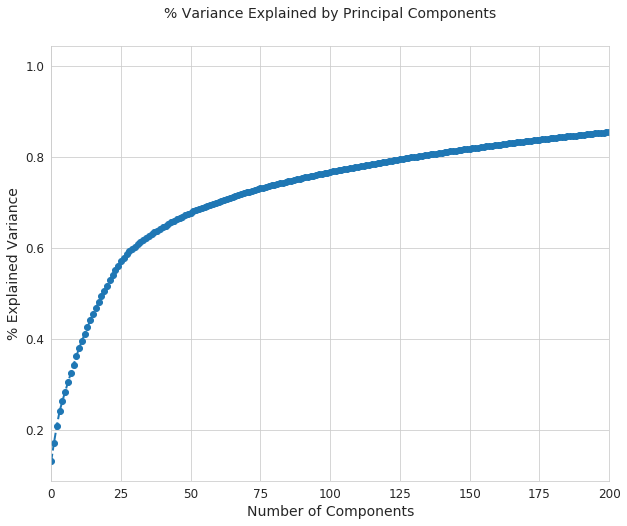

In [104]:
X_train, X_test = train_test_split(fs, test_size=0.2, random_state=0)
X=X_train.drop(['Target'] , axis=1)
y=X_train.Target.values
feature_name = X.columns.tolist()
X=np.nan_to_num(X)
scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

sns.set_style('whitegrid')
pca = PCA(random_state=0)
pca.fit(scaled_X)
plt.figure(1, figsize=(10, 8))
plt.plot(np.cumsum(pca.explained_variance_ratio_),'--o', linewidth=2)
plt.axis('tight')
plt.xlabel('Number of Components',size=14)
plt.xticks(size=12)
plt.xlim([0,200])
plt.ylabel('% Explained Variance',size=14)
plt.yticks(size=12)
plt.title('% Variance Explained by Principal Components',size=14,y=1.05)
plt.show()

In [105]:
pca=PCA(n_components=125,whiten=True,random_state=0)
X_pca_21=pca.fit_transform(scaled_X)
print("Variance explained using 125 components is:",sum(pca.explained_variance_ratio_))
y_test = X_test['Target']
X_test = X_test.drop(['Target'], axis=1)
X_test_pca = pca.transform(X_test)

Variance explained using 125 components is: 0.793298797248239


In [107]:
rf_model = RandomForestClassifier(random_state=0)

et_model = ExtraTreesClassifier(random_state=0)

grad_model = GradientBoostingClassifier(random_state=0)


base_est =[ ( 'rf' , rf_model ) , ( 'gradient' , grad_model ) , ( 'extratree' , et_model ) ]


print('\033[1m' + 'Voting Classifier' + '\033[0m')
vc_model=VotingClassifier(estimators = base_est, voting = 'soft', weights = [1,1,1] )
vc_model.fit(X_pca_21,y)
vc_model,acc_train,acc_test,roc_auc,mcc,precision,recall=model_build(vc_model,X_pca_21,y,X_test_pca,y_test,tree=False,feat=None)
print("MCC : ", mcc)
print("Precison : ",precision)
print("Recall : ",recall)
print("AUC : " , roc_auc)

Voting Classifier
Accuracy of the model for training data is: 0.997958272187839
Confusion Matrix for training data is:


col_0,0,1
row_0,,
0,27785,7
1,57,3497


Accuracy of the model for test data is: 0.8938369273956871
Confusion Matrix for test data is:


col_0,0,1
Target,,
0,6935,15
1,817,70


MCC :  0.23478459063739215
Precison :  0.8235294117647058
Recall :  0.07891770011273957
AUC :  0.5383797133657222


In [2]:
### Darshan Bhansali
### HTML code to hide the input cells 
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To toggle code, click <a href="javascript:code_toggle()">here</a>.''')